# Lotka Volterra UPINN

In [1]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from utils import SINDy_sklearn, sample_collocation_points

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [2]:
# Data
alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
X0 = torch.tensor([1.0, 1.0]).reshape(-1, 2)

Nd = 10 # Number of data points

time_int = [0, 20]
spacing = (time_int[1] - time_int[0]) / Nd

data_time_points = np.linspace(time_int[0]+spacing, time_int[1], Nd)

data = LotkaVolterraData(X0, alpha, beta, gamma, delta, time_int, time_points=data_time_points)

td = data.td
Xd = data.Xd

In [3]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0

In [4]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [5]:
class SparseLV(torch.nn.Module):
    
    def __init__(self, params):
        super(SparseLV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']

    def forward(self, z, U):

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - alpha*U[:, 0], # + beta*U[:, 0]*U[:, 1],
            dUdt[:, 1] + delta*U[:, 1] # - gamma*U[:, 0]*U[:, 1] # <-- Estimate this
        ], dim=-1)


params = dict(
    alpha=alpha,
    beta=beta,
    delta=delta,
    gamma=gamma
)

N = SparseLV(params)

### Problem specific UPINN functions

In [6]:
class LV_UPINN(UPINN):

    # def get_loss(self):
    #     bc_loss = self.bc_loss()
    #     data_loss = self.data_loss()
    #     pde_loss = self.pde_loss()
    #     lambdas = SoftAdapt(**self.softadapt_kwargs)(torch.tensor([bc_loss, data_loss, pde_loss]))
    #     loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss

    #     return loss, bc_loss, data_loss, pde_loss

    def F_input(self, z, U):
        return U

    def score(self):
        u_pred = self.u(data.t_full)

        L2_rel_error = torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
        return L2_rel_error.item()

        # return torch.nn.MSELoss()(u_pred, data.X_full)
    
    def score_residual(self):
        u_pred = self.u(data.t_full)
        F_pred = self.F(self.F_input(data.t_full, u_pred))
               
        F_exp_1 = beta*u_pred[:, 0]*u_pred[:, 1]
        F_exp_2 = -gamma*u_pred[:, 0]*u_pred[:, 1]
        F_exp = torch.stack([F_exp_1, F_exp_2], dim=-1)

        L2_rel_error = torch.sqrt(torch.mean((F_pred - F_exp)**2) / torch.mean(F_exp**2))
        return L2_rel_error.item()

        

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(self.collocation_points)
            F_pred = self.F(self.F_input(t_plot, u_pred))

            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            fig, ax = plt.subplots(2, 1, figsize=(8, 6))
            plt.subplot(2, 1, 1)
            plt.plot(td, Xd[:, 0], 'rx')
            plt.plot(td, Xd[:, 1], 'bx')
            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.scatter(td, Xd[:, 0], color='r')
            plt.scatter(td, Xd[:, 1], color='b')
            plt.xlabel('t')
            plt.legend()
            
            plt.subplot(2, 1, 2)
            plt.plot(t_plot, F_pred[:, 0], 'r', label='Predator residual')
            plt.plot(t_plot, F_pred[:, 1], 'b', label='Prey residual')
            plt.plot(t_plot, beta*x_true*y_true, 'r--')
            plt.plot(t_plot, -gamma*x_true*y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig('gfx/'+save+'.pdf', format='pdf', bbox_inches='tight')

            plt.show()


### Setup UPINN

In [7]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)
F = FNN(
    dims=[2, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [8]:
model = LV_UPINN(u, N, F, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)

[Info]: Initializing UPINN model


### Train

In [9]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, factor=0.5, patience=200, threshold=1e-3)
model.scheduler = scheduler
model.optimizer = adamw

In [ ]:
model.train_loop(30000, device='cpu')

[Info]: Training 30000 epoch(s) on cpu using AdamW optimizer.


[CPU]:   2%|▏         | 743/30000 [00:07<04:44, 102.87 epoch/s, bc_loss=2.43e-07, data_loss=1.02e-01, pde_loss=6.47e-04, loss=1.03e-01]

In [ ]:
model.save('lv_baseline_long', 'models')

[Info]: Successfully saved total model with name lv_baseline at models


In [506]:
model.load('lv_baseline', 'models')

In [531]:
model.freeze_F()
model.collocation_points = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[1.7*time_int[1]], method='grid').requires_grad_(True)

In [534]:
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
model.optimizer = adam
model.train_loop(5000)

[Info]: Training 5000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 5000/5000 [01:00<00:00, 82.74 epoch/s, bc_loss=8.91e-08, data_loss=5.22e-07, pde_loss=1.25e-05, loss=1.31e-05]


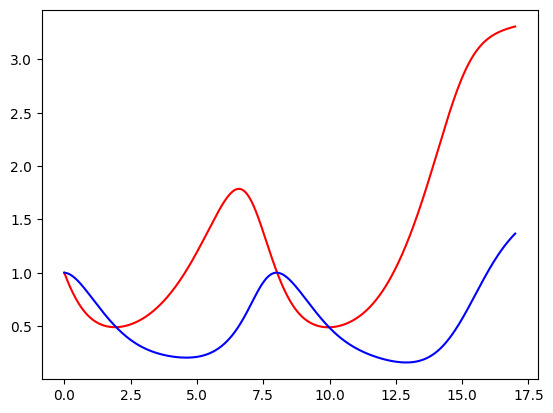

In [535]:
t = model.collocation_points
u = model.u(t)

plt.plot(t.detach().numpy(), u[:, 0].detach().numpy(), 'r')
plt.plot(t.detach().numpy(), u[:, 1].detach().numpy(), 'b')
plt.show()

In [546]:
# Inspect parameters of F
for name, param in model.u.named_parameters():
    print(name, param)

scalinglayer.scale Parameter containing:
tensor([1.], requires_grad=True)
scalinglayer.bias Parameter containing:
tensor([0.], requires_grad=True)
layers.0.scale Parameter containing:
tensor([0.8614], requires_grad=True)
layers.0.bias Parameter containing:
tensor([-0.2819], requires_grad=True)
layers.1.weight Parameter containing:
tensor([[-0.2049],
        [-0.2610],
        [-0.5397],
        [-1.3912],
        [ 0.4820],
        [-0.0947],
        [-0.0766],
        [-0.2902],
        [ 0.0661],
        [ 0.8689],
        [ 0.4475],
        [-0.0771],
        [-0.2699],
        [-0.0579],
        [ 0.0824],
        [ 0.5225]], requires_grad=True)
layers.1.bias Parameter containing:
tensor([ 0.3095, -0.1289,  0.1375, -0.1496, -0.1498,  0.1840,  0.1058, -0.1972,
        -0.0199,  0.1500, -0.0986,  0.2420,  0.3329, -0.0071, -0.1071, -0.1552],
       requires_grad=True)
layers.3.weight Parameter containing:
tensor([[ 0.3220, -0.2162, -0.6706,  0.0184,  0.5424,  0.5150,  0.6695, -0.0481,

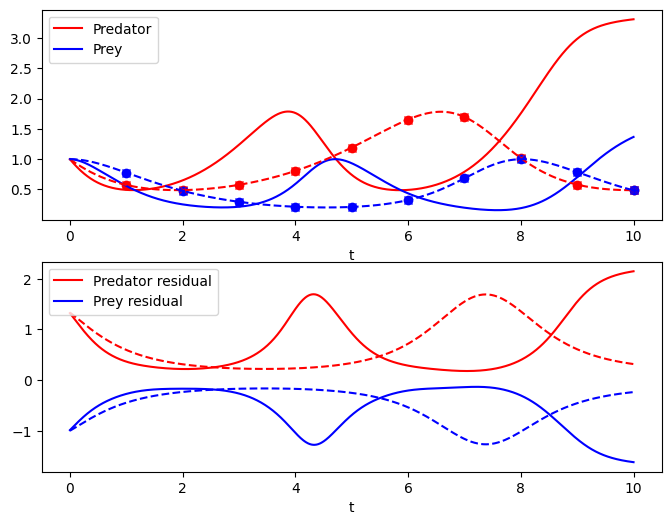

In [536]:
model.plot()

In [234]:
# upinn.load('lv_upinn_baseline_10_datapoints', 'models')

In [235]:
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

In [243]:
# Generate data from the solution network
t = data.t_full
X = upinn.u(t)
X_dot = upinn.F(upinn.F_input(None, X))
t = t.detach().numpy()
X = X.detach().numpy()
X_dot = X_dot.detach().numpy()

In [249]:
t.shape

(1000, 1)

In [266]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
model = SINDy_sklearn(feature_names=['x', 'y'], feature_library=ps.PolynomialLibrary(degree=2), optimizer=ps.SR3(thresholder="L1", max_iter=10000, normalize_columns=True))
paramgrid = dict(optimizer__threshold=np.linspace(0.01, 10.0, 100))

cv_folds = TimeSeriesSplit(n_splits=10)
model_selector = GridSearchCV(model, param_grid=paramgrid, cv=cv_folds, n_jobs=-1)
wrapped_input = np.concatenate([t, X], axis=1)
model_selector.fit(wrapped_input, X_dot)
best_model = model_selector.best_estimator_

best_model.print()

(x)' = 1.334 x y
(y)' = -1.000 x y
